# Experiment 1: No-fire December set (PWWB + AirNow)

This notebook focuses on running Experiment 1, which uses data from December (no-fire period) combining PWWB and AirNow datasets.

# Data parameters

In [1]:
# define bounding box
lat_bottom, lat_top = 33.9, 34.2
lon_bottom, lon_top = -118.4, -118.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# input data shape
dim = 200
frames_per_sample = 5

# date range of data - December only for this experiment
dec_start_date, dec_end_date = "2024-12-16-00", "2024-12-23-00"

# Data ingestion and preprocessing

In [2]:
# python nonsense that allows you to import from sibling directories
import sys
sys.path.append("..")

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dotenv import load_dotenv

# Import the data classes
from libs.pwwbdata import PWWBData
from libs.airnowdata import AirNowData

# Load environment variables (API keys, credentials)
load_dotenv()

# split data
def train_test_split(X, train_size=0.75):
    split_idx = int(X.shape[0] * train_size)
    X_train, X_test = X[:split_idx], X[split_idx:]
    
    return X_train, X_test

# scale training data, then scale test data based on training data stats
from sklearn.preprocessing import StandardScaler
def std_scale(X_train, X_test):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
    scaled_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

    return scaled_train, scaled_test

In [3]:
# Create output directory for results
output_dir = "experiment_output"
os.makedirs(output_dir, exist_ok=True)
dec_end_date_adj = pd.to_datetime(dec_end_date) - pd.Timedelta(hours=1)

# ========== 1. Load December PWWB Data ==========
print("\nLoading December PWWB data...")
dec_pwwb = PWWBData(
    start_date=dec_start_date,
    end_date=dec_end_date,
    extent=extent,
    frames_per_sample=frames_per_sample,
    dim=dim,
    env_file='.env',
    verbose=True,
    output_dir=output_dir
)
X_dec_pwwb = dec_pwwb.data
channel_info = dec_pwwb.get_channel_info()
print(f"✓ December PWWB data shape: {X_dec_pwwb.shape}")
print(f"  Channels: {channel_info['channel_order']}")

# ========== 2. Load December AirNow Data ==========
print("\nLoading December AirNow data...")
dec_airnow = AirNowData(
    start_date=dec_start_date,
    end_date=dec_end_date_adj,
    extent=extent,
    airnow_api_key=os.getenv('AIRNOW_API_KEY'),
    frames_per_sample=frames_per_sample,
    dim=dim,
    elevation_path="../libs/inputs/elevation.npy",
    mask_path="../libs/inputs/mask.npy",
    force_reprocess=False
)
X_dec_airnow = dec_airnow.data
Y_dec = dec_airnow.target_stations
print(f"✓ December AirNow data shape: {X_dec_airnow.shape}")
if Y_dec is not None:
    print(f"  December target stations shape: {Y_dec.shape}")
else:
    print("  No December target stations available")


Loading December PWWB data...
Initialized PWWBData with 168 hourly timestamps
Date range: 2024-12-16 00:00:00 to 2024-12-22 23:00:00
Initialized PWWBData with 168 hourly timestamps
Date range: 2024-12-16 00:00:00 to 2024-12-22 23:00:00
Processing remote-sensing satellite imagery...
Loading cached MAIAC AOD data from data/pwwb_cache/maiac_aod_data.npy
Loading cached TROPOMI data from data/pwwb_cache/tropomi_data.npy
Processing wildfire/smoke data...
Loading cached MODIS fire data from data/pwwb_cache/modis_fire_data.npy
Loading cached MERRA-2 data from data/pwwb_cache/merra2_data.npy
Processing meteorological data...
Loading cached METAR data from data/pwwb_cache/metar_data.npy
Final data shape: (164, 5, 200, 200, 16)

Channel Statistics:

Channel 0: MAIAC_AOD
  Min: -28672.000000000007
  Max: -11405.030979015683
  Mean: -24606.076704338277
  Std: 4386.375562710705
  Data coverage: 100.00% (40000/40000 non-zero pixels)

Channel 1: TROPOMI_Methane
  Min: 1938.3544581494239
  Max: 1947.8

In [4]:
# ========== 3. Create Experiment 1 dataset ==========
print("\nCreating Experiment 1 dataset...")

# Experiment 1: No-fire December set (PWWB + AirNow)
print("  Experiment 1: No-fire December set (PWWB + AirNow)")
X_exp1 = np.concatenate([X_dec_pwwb, X_dec_airnow], axis=-1)
print(f"    Combined shape: {X_exp1.shape}")


Creating Experiment 1 dataset...
  Experiment 1: No-fire December set (PWWB + AirNow)
    Combined shape: (164, 5, 200, 200, 17)


In [5]:
# ========== 4. Train/Test Split for experiment ==========
print("\nCreating train/test splits for experiment...")
# Experiment 1 splits
X_exp1_train, X_exp1_test = train_test_split(X_exp1, train_size=0.75)
Y_dec_train, Y_dec_test = train_test_split(Y_dec, train_size=0.75)
print(f"  Experiment 1: Train={X_exp1_train.shape}, Test={X_exp1_test.shape}")

# ========== 5. Standardize data ==========
print("\nStandardizing data...")

# Experiment 1 standardization
X_exp1_train_scaled, X_exp1_test_scaled = std_scale(X_exp1_train, X_exp1_test)
print(f"  Experiment 1: Scaled train={X_exp1_train_scaled.shape}, test={X_exp1_test_scaled.shape}")


Creating train/test splits for experiment...
  Experiment 1: Train=(123, 5, 200, 200, 17), Test=(41, 5, 200, 200, 17)

Standardizing data...
  Experiment 1: Scaled train=(123, 5, 200, 200, 17), test=(41, 5, 200, 200, 17)


In [6]:
# ========== 6. Save prepared datasets ==========
print("\nSaving prepared dataset...")

# Create directory for experiment
exp_dir = os.path.join(output_dir, "experiment1")
os.makedirs(exp_dir, exist_ok=True)

# Save Experiment 1 data
np.save(os.path.join(exp_dir, "X_train.npy"), X_exp1_train_scaled)
np.save(os.path.join(exp_dir, "X_test.npy"), X_exp1_test_scaled)
np.save(os.path.join(exp_dir, "y_train.npy"), Y_dec_train)
np.save(os.path.join(exp_dir, "y_test.npy"), Y_dec_test)

print("\n✓ Dataset prepared and saved!")


Saving prepared dataset...

✓ Dataset prepared and saved!


# Data visualization

Visualizing data...


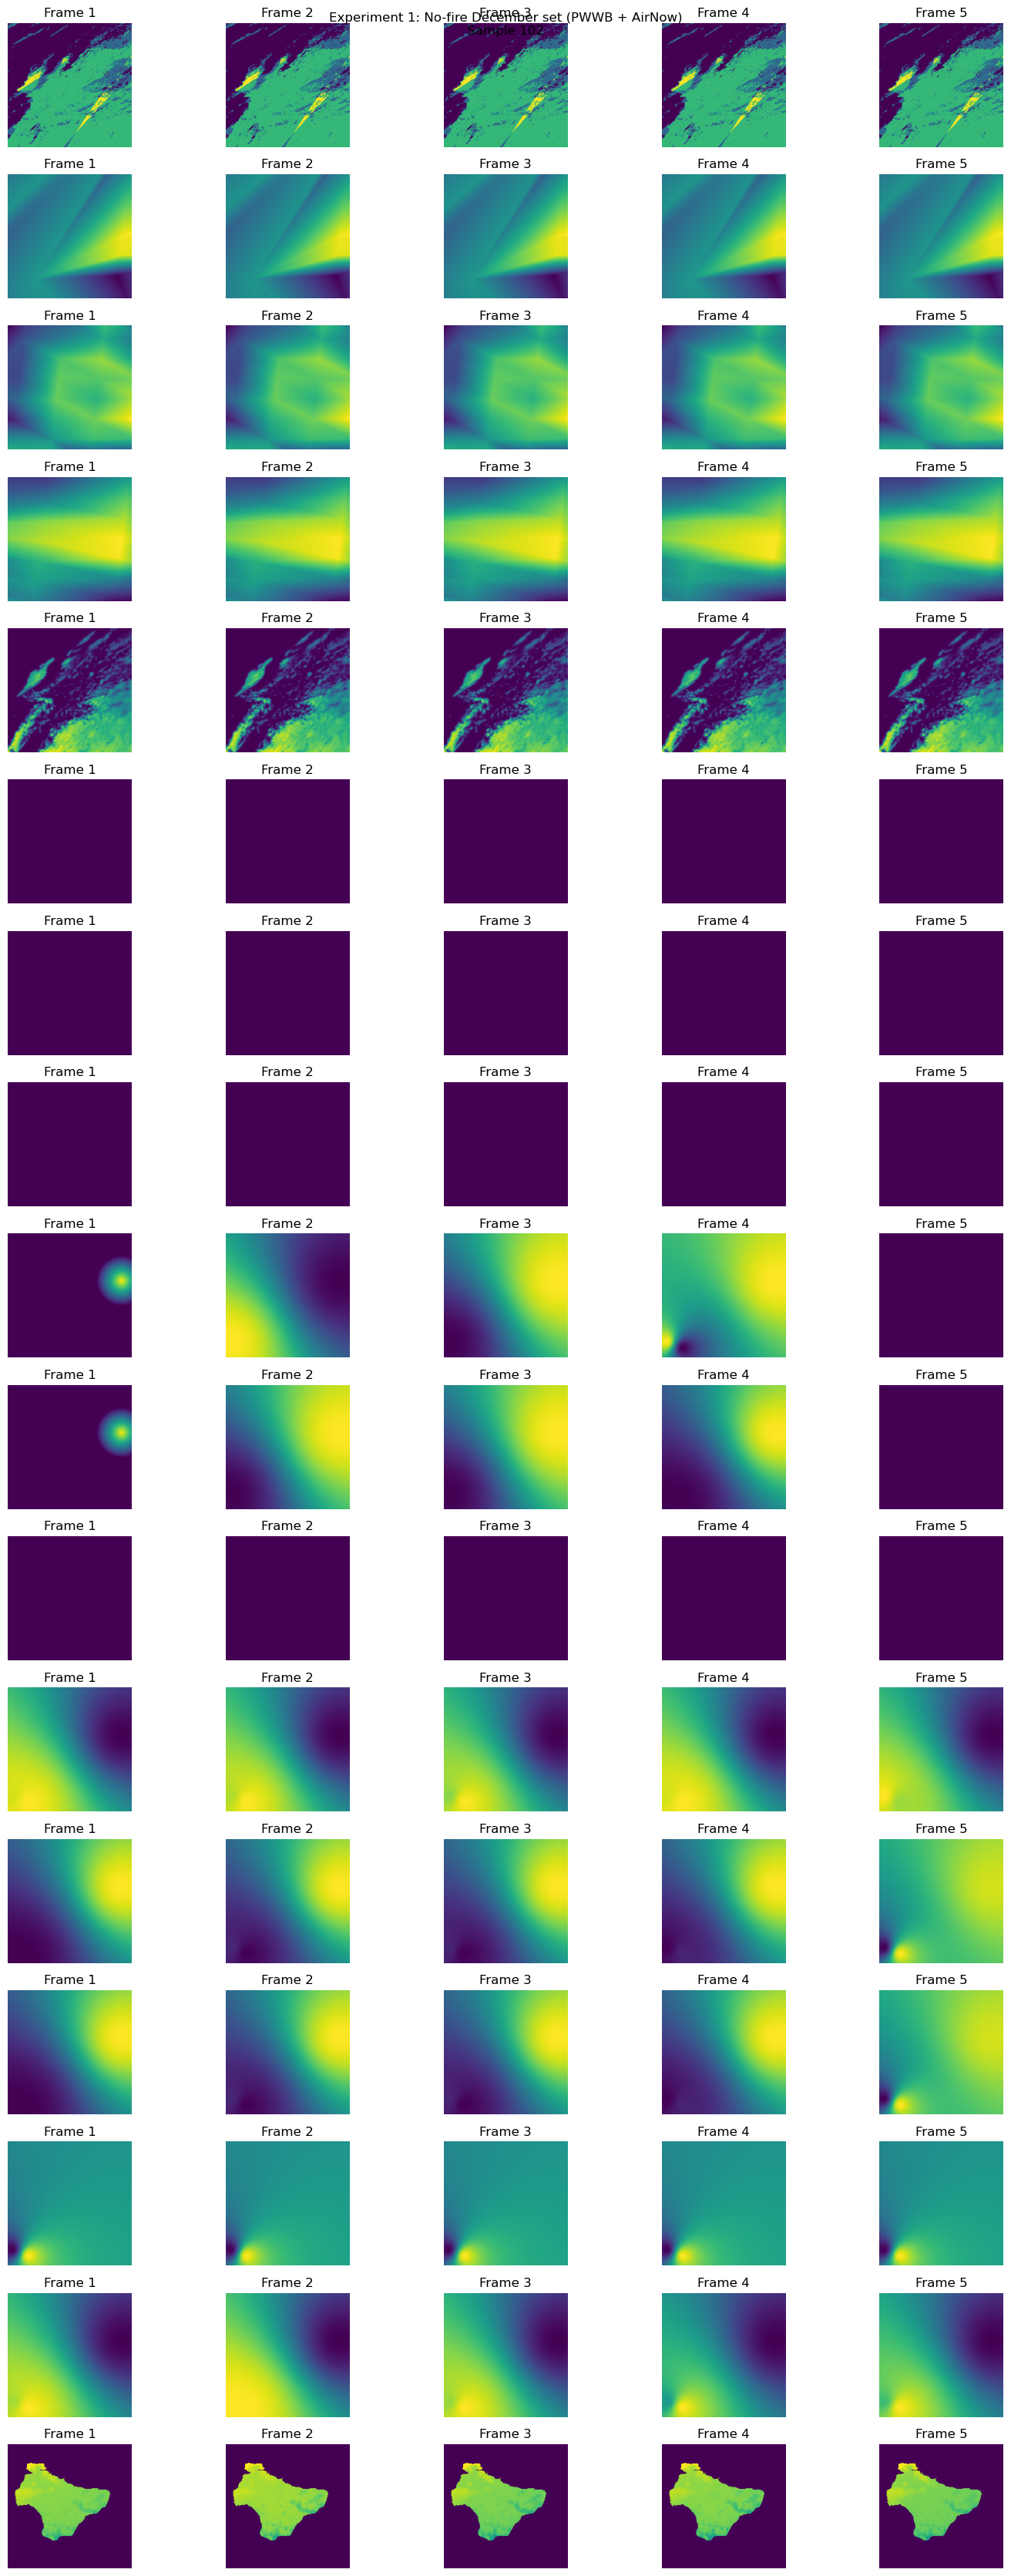

Target values: [26.6 23.5 10.2]


In [7]:
# Function to visualize data from experiment
def visualize_experiment_data(X, y, sample_idx=None):
    """Visualize data from the experiment"""
    # Get a random sample if none provided
    if sample_idx is None:
        np.random.seed(42)
        sample_idx = np.random.choice(range(len(X)), size=1)[0]
    
    # Get channel information
    n_channels = X.shape[4]
    n_frames = X.shape[1]
    
    # Create figure
    fig, axes = plt.subplots(n_channels, n_frames, figsize=(3*n_frames, 2*n_channels))
    if n_channels == 1:
        axes = axes.reshape(1, -1)
    
    # Plot each channel and frame
    for c in range(n_channels):
        for f in range(n_frames):
            ax = axes[c, f]
            ax.imshow(X[sample_idx, f, :, :, c])
            if f == 0:
                ax.set_ylabel(f"Channel {c}")
            ax.set_title(f"Frame {f+1}")
            ax.axis("off")
    
    # Set title
    plt.suptitle(f"Experiment 1: No-fire December set (PWWB + AirNow)\nSample {sample_idx}")
    plt.tight_layout()
    plt.show()
    
    # Print target values
    print(f"Target values: {y[sample_idx]}")

# Visualize a sample from the experiment
print("Visualizing data...")
visualize_experiment_data(X_exp1_train_scaled, Y_dec_train)

# Model

In [8]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer

tf.keras.backend.set_image_data_format('channels_last')

2025-05-20 09:59:13.894258: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-20 09:59:13.918003: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-20 09:59:15.125768: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.



==== Running Experiment 1: No-fire December set (PWWB + AirNow) ====
Training data shape: (123, 5, 200, 200, 17)
Target data shape: (123, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 200, 200,    │        17,340 │
│                                 │ 15)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 200, 200,    │        48,720 │
│                                 │ 30)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 200, 200,    │        12,165 │
│                                 │ 15)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 200, 200, 1) │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │       600,003 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 678,634 (2.59 MB)

 Trainable params: 678,634 (2.59 MB)

 Non-trainable params: 0 (0.00 B)


Training model...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 429ms/step - loss: 12.3103 - val_loss: 16.8841
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 410ms/step - loss: 7.4809 - val_loss: 13.6719
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 384ms/step - loss: 6.0728 - val_loss: 13.1546
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 424ms/step - loss: 6.3364 - val_loss: 15.7457
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 428ms/step - loss: 6.2954 - val_loss: 15.5592
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 393ms/step - loss: 6.9979 - val_loss: 9.9230
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 424ms/step - loss: 6.4433 - val_loss: 15.9830
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 430ms/step - loss: 6.0854 - val_loss: 11.7925
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 393ms/step - loss: 6.6884 - val_loss: 13.0383
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 418ms/step - loss: 5.8845 - val_loss: 14.5844
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 421ms/step - loss: 6.2625 - val_loss: 14.9873
Epoch 12/50

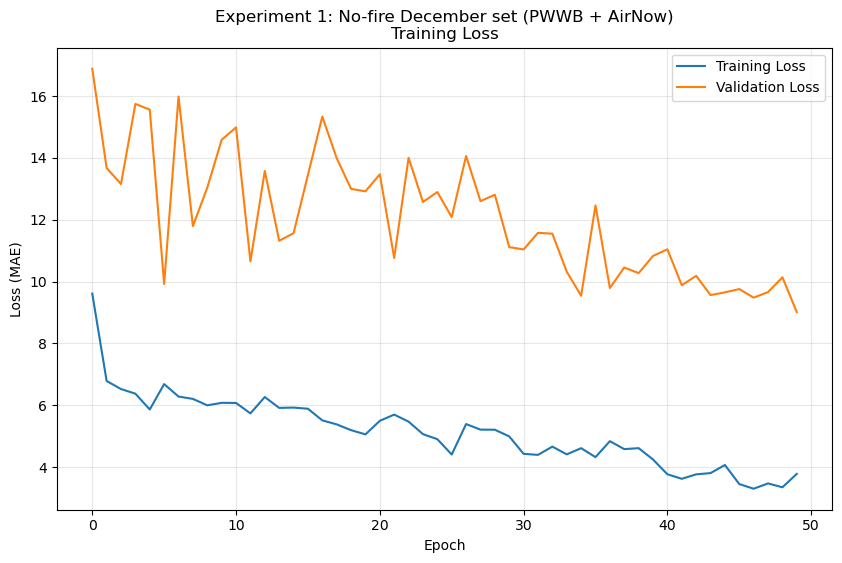

In [ ]:
# Run Experiment 1: No-fire December set (PWWB + AirNow)
print("\n==== Running Experiment 1: No-fire December set (PWWB + AirNow) ====")
print(f"Training data shape: {X_exp1_train_scaled.shape}")
print(f"Target data shape: {Y_dec_train.shape}")

# Build model
seq = Sequential()

seq.add(
    InputLayer(shape=X_exp1_train_scaled.shape[1:])
)

seq.add(
    ConvLSTM2D(
            filters=15, 
            kernel_size=(3, 3),
            padding='same', 
            return_sequences=True
    )
)

seq.add(
    ConvLSTM2D(
        filters=30, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True
    )
)

seq.add(
    Conv3D(
        filters=15, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'    
    )
)

seq.add(
    Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'
    )
)

seq.add(Flatten())
seq.add(Dense(Y_dec_train.shape[1], activation='relu'))

# Compile model
seq.compile(loss='mean_absolute_error', optimizer='adam')

# Print model summary
seq.summary()

# Train model
print(f"\nTraining model...")
epochs = 50  # Reduced epochs for faster testing
batch_size = 4
history = seq.fit(
    X_exp1_train_scaled, Y_dec_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2
)

# Evaluate model
print(f"\nEvaluating model...")
test_loss = seq.evaluate(X_exp1_test_scaled, Y_dec_test, verbose=0)
print(f"Test MAE: {test_loss:.4f}")

# Make predictions
y_pred = seq.predict(X_exp1_test_scaled, verbose=0)

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(Y_dec_test, y_pred)
rmse = np.sqrt(mean_squared_error(Y_dec_test, y_pred))
r2 = r2_score(Y_dec_test, y_pred)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
plt.title('Experiment 1: No-fire December set (PWWB + AirNow)\nTraining Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.grid(True, alpha=0.3)
plt.show()

# Save results
results_dir = os.path.join(output_dir, "experiment1", "results")
os.makedirs(results_dir, exist_ok=True)

np.save(os.path.join(results_dir, "y_pred.npy"), y_pred)
seq.save(os.path.join(results_dir, "model.h5"))

exp1_results = {
    'model': seq,
    'history': history,
    'loss': test_loss,
    'mae': mae,
    'rmse': rmse,
    'r2': r2,
    'y_pred': y_pred,
    'y_test': Y_dec_test
}

# Evaluate

In [ ]:
print(f"\nDetailed analysis for Experiment 1:")
X_test = X_exp1_test_scaled
y_test = Y_dec_test
y_pred = exp1_results['y_pred']
model = exp1_results['model']
description = "No-fire December set (PWWB + AirNow), 3rd week"

print(f"Analyzing Experiment 1: {description}")


Detailed analysis for Experiment 1:
Analyzing Experiment 1: No-fire December set (PWWB + AirNow), 3rd week



1. Plotting prediction comparison...


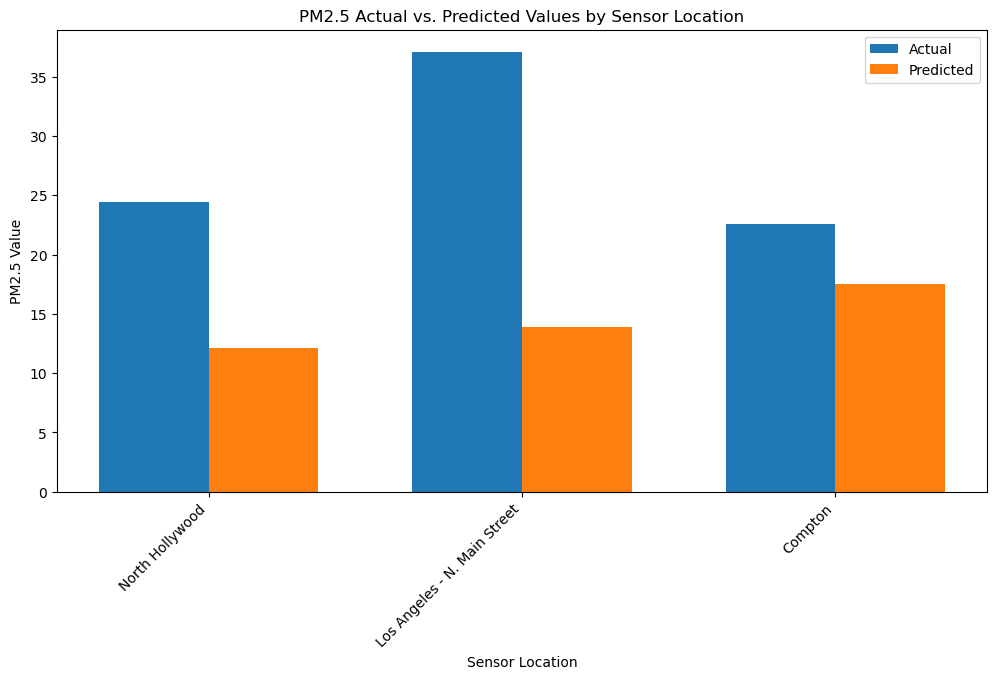


2. Plotting scatter comparison...


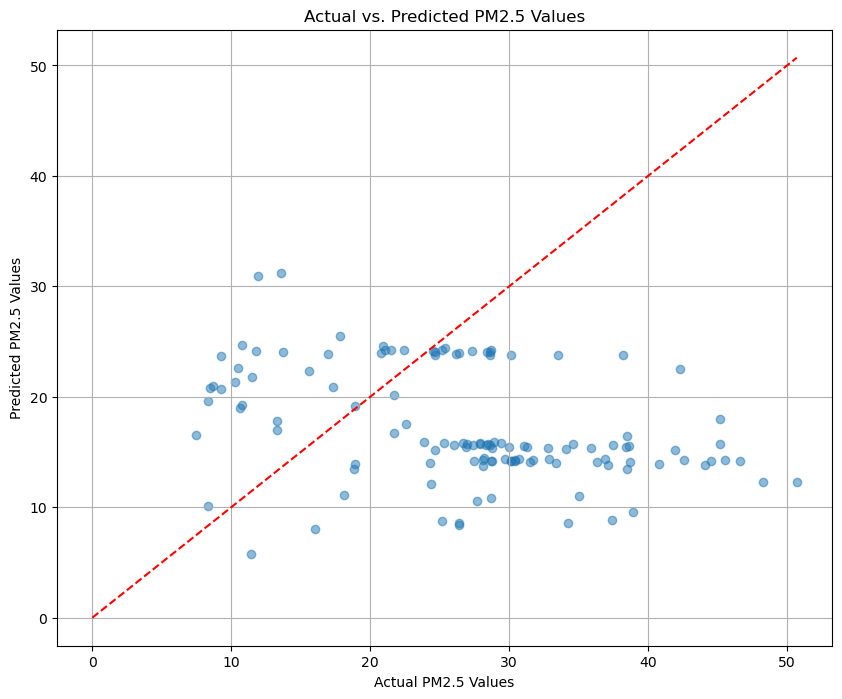


3. Plotting error by sensor...


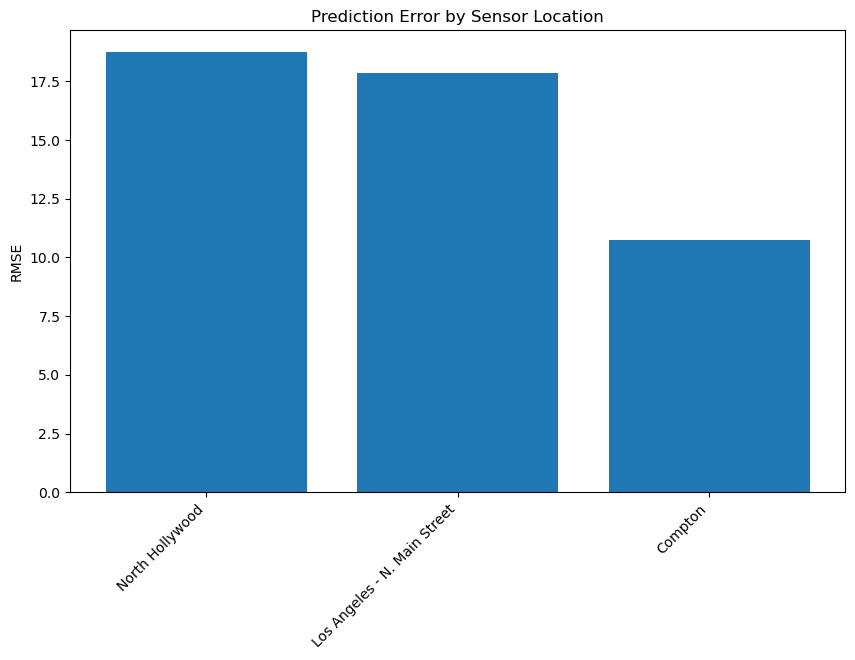


4. Plotting time series comparison...


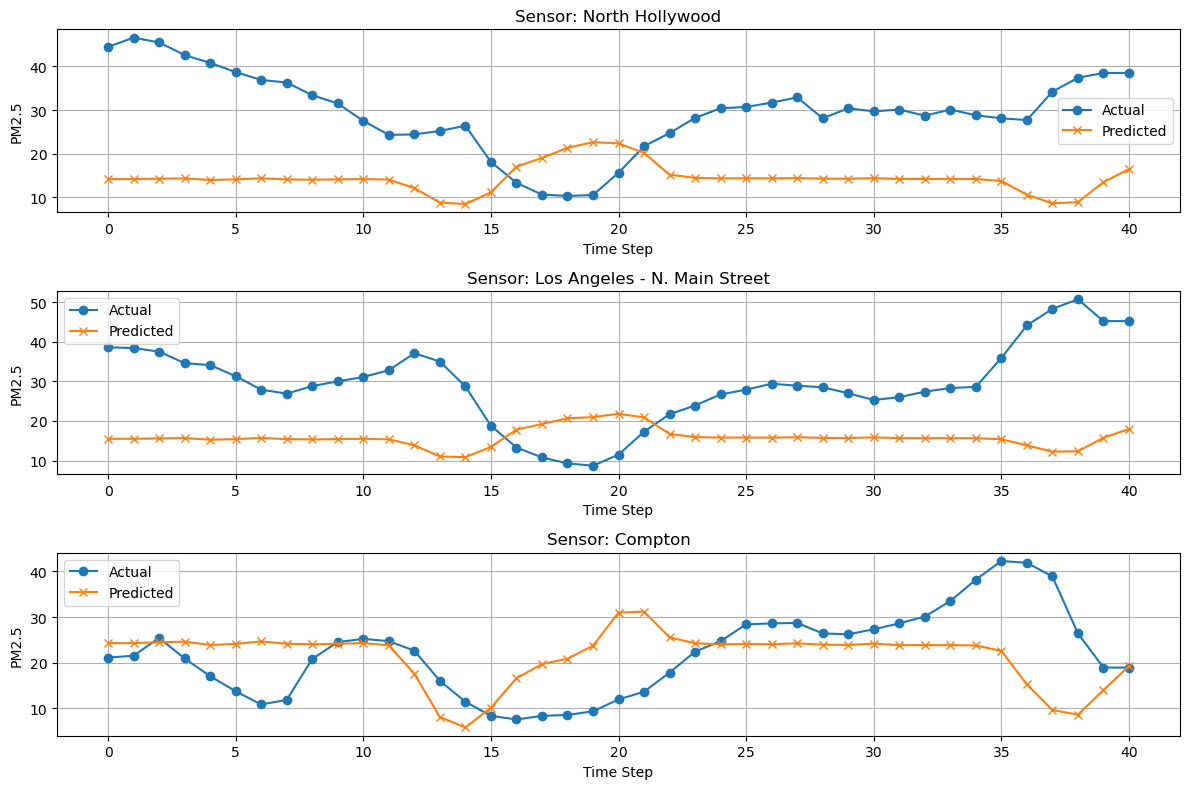


5. Plotting time series with shifted predictions...


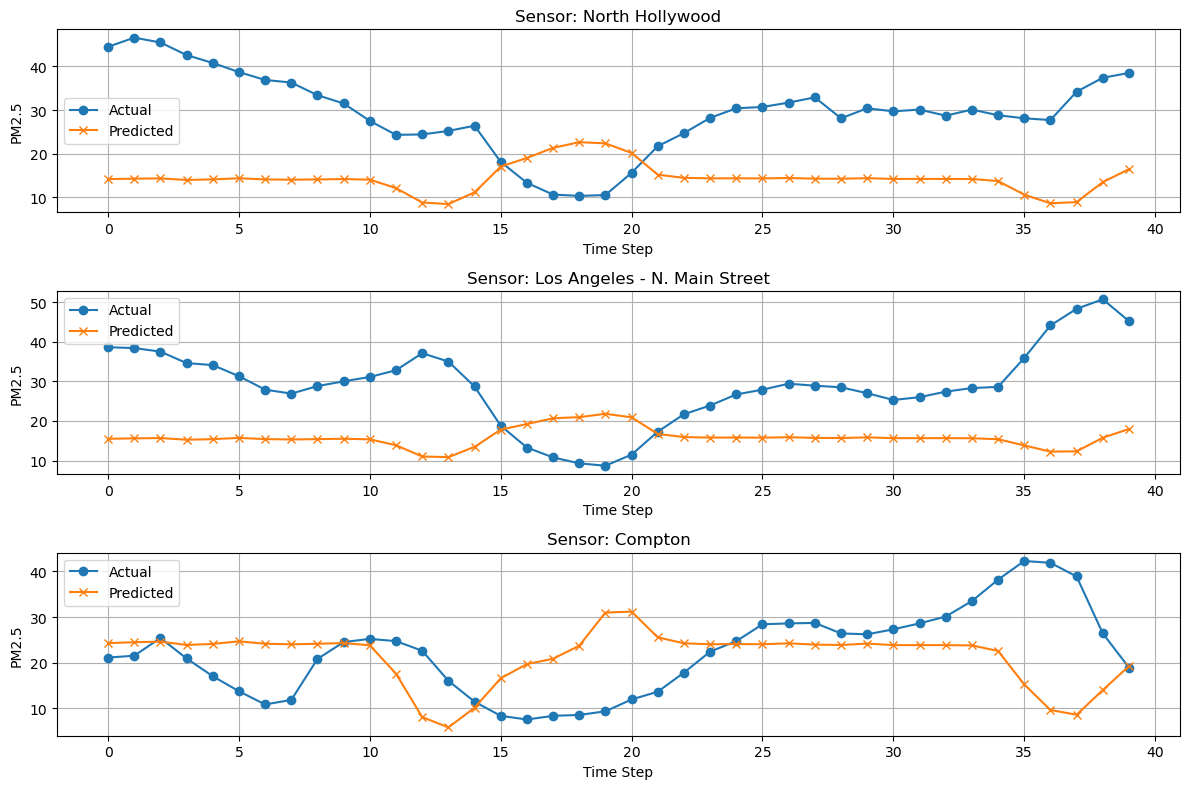


6. Printing metrics...
RESULTS
---------------------------------------------------------------------------
All Days All Locations - y_pred vs y_test Raw RMSE: 16.17
All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: 59.94%

RESULTS BY FRAME
---------------------------------------------------------------------------
Frame 1 (Hour 1) All Locations - Raw RMSE: 22.09
Frame 1 (Hour 1) All Locations - RMSE Percent Error of Mean: 63.60%

Frame 2 (Hour 2) All Locations - Raw RMSE: 22.99
Frame 2 (Hour 2) All Locations - RMSE Percent Error of Mean: 64.75%

Frame 3 (Hour 3) All Locations - Raw RMSE: 22.03
Frame 3 (Hour 3) All Locations - RMSE Percent Error of Mean: 60.98%

Frame 4 (Hour 4) All Locations - Raw RMSE: 19.76
Frame 4 (Hour 4) All Locations - RMSE Percent Error of Mean: 60.44%

Frame 5 (Hour 5) All Locations - Raw RMSE: 19.34
Frame 5 (Hour 5) All Locations - RMSE Percent Error of Mean: 63.14%

Frame 6 (Hour 6) All Locations - Raw RMSE: 17.95
Frame 6 (Hour 6) All Loc

In [14]:
from libs.plotting import (
    plot_prediction_comparison,
    plot_scatter_comparison,
    plot_error_by_sensor,
    plot_time_series_comparison,
    plot_input_frames,
    print_metrics
)

# Sensor names (use AirNow sensor names if available)
if hasattr(dec_airnow, 'sensor_names') and dec_airnow.sensor_names is not None:
    sensor_names = dec_airnow.sensor_names
else:
    sensor_names = ["North Hollywood", "Los Angeles - N. Main Street", "Compton"]

print("\n1. Plotting prediction comparison...")
plot_prediction_comparison(y_pred, y_test, sensor_names, sample_idx=12)

print("\n2. Plotting scatter comparison...")
plot_scatter_comparison(y_pred, y_test)

print("\n3. Plotting error by sensor...")
plot_error_by_sensor(y_pred, y_test, sensor_names)

print("\n4. Plotting time series comparison...")
plot_time_series_comparison(y_pred, y_test, sensor_names)
    
print("\n5. Plotting time series with shifted predictions...")
plot_time_series_comparison(y_pred, y_test, sensor_names, shift_pred=1)

print("\n6. Printing metrics...")
print_metrics(y_pred, y_test, sensor_names)

In [ ]:
# Save experiment comparison
with open(os.path.join(output_dir, 'experiment1_results.txt'), 'w') as f:
    f.write("==== Experiment 1 Results ====\n")
    f.write(f"Experiment 1 (No-fire December, 3rd week): MAE = {exp1_results['mae']:.4f}, RMSE = {exp1_results['rmse']:.4f}, R² = {exp1_results['r2']:.4f}\n")
    f.write(f"\nAnalysis completed on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

print("\nExperiment 1 complete!")


Experiment 1 complete!


: 